In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.io
from scipy import signal

import itertools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pmdarima.arima import auto_arima, ADFTest

In [2]:
mat = scipy.io.loadmat('PowerValuesOctMay.mat')
m = mat['MeasurementsTotal']

In [3]:
m = np.squeeze(m)

# Data Exploration

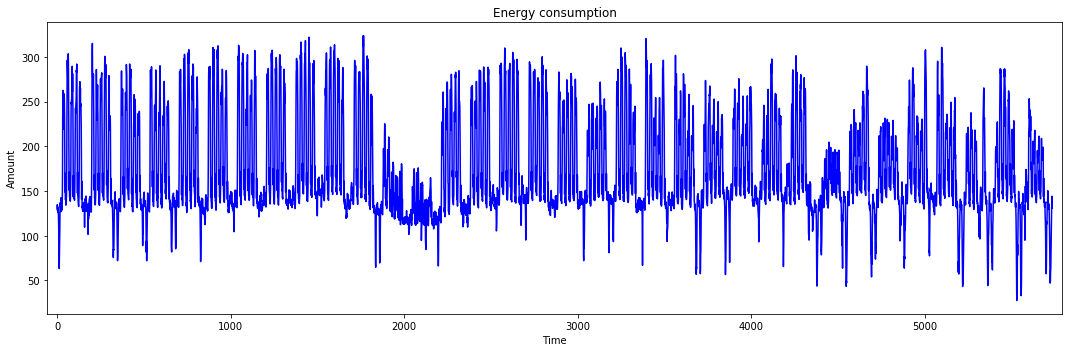

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))

ax.plot(m, c='b')
ax.set_title('Energy consumption')
ax.set_xlabel('Time')
ax.set_ylabel('Amount')
ax.margins(x=0.01)
plt.tight_layout()
plt.savefig('p1_complete_data.png', dpi=300)
plt.show()

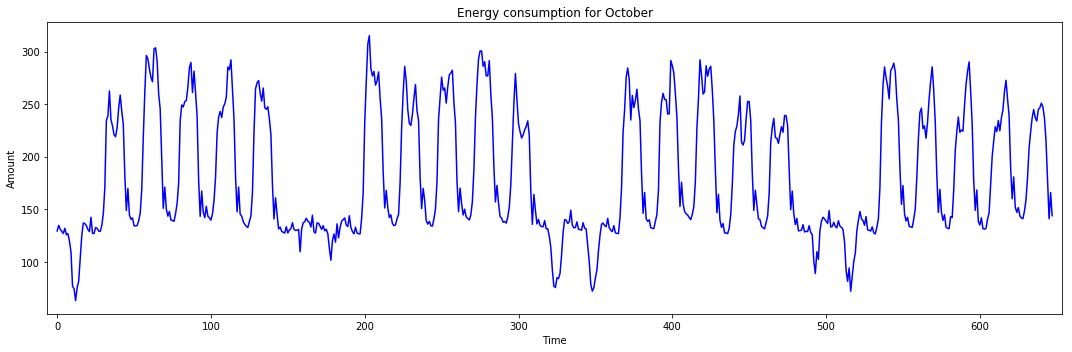

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))

ax.plot(m[:27*24], c='b')
ax.set_title('Energy consumption for October')
ax.set_xlabel('Time')
ax.set_ylabel('Amount')
ax.margins(x=0.01)
plt.tight_layout()
plt.savefig('p1_october_data.png', dpi=300)
plt.show()

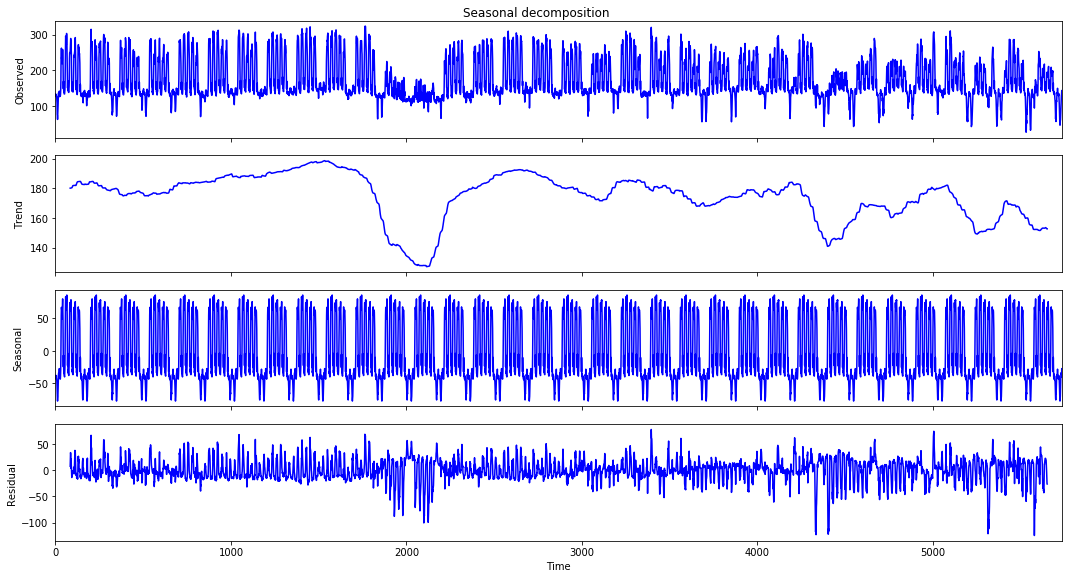

In [76]:
matplotlib.rcParams['figure.figsize'] = [15.0, 8.0]
from cycler import cycler
matplotlib.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

sd = seasonal_decompose(m, model='additive', freq=168)


fig = sd.plot()
fig.suptitle('Seasonal decomposition', y=1.0)
plt.tight_layout()
plt.savefig('p1_decomposition.png', dpi=300)
plt.show()

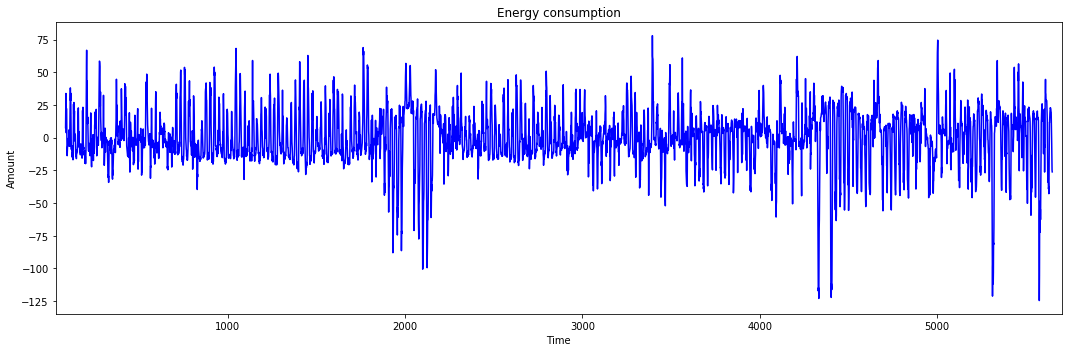

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))

ax.plot(sd.resid, c='b')
ax.set_title('Energy consumption')
ax.set_xlabel('Time')
ax.set_ylabel('Amount')
ax.margins(x=0.01)
plt.tight_layout()
plt.savefig('p1_residuals.png', dpi=300)
plt.show()

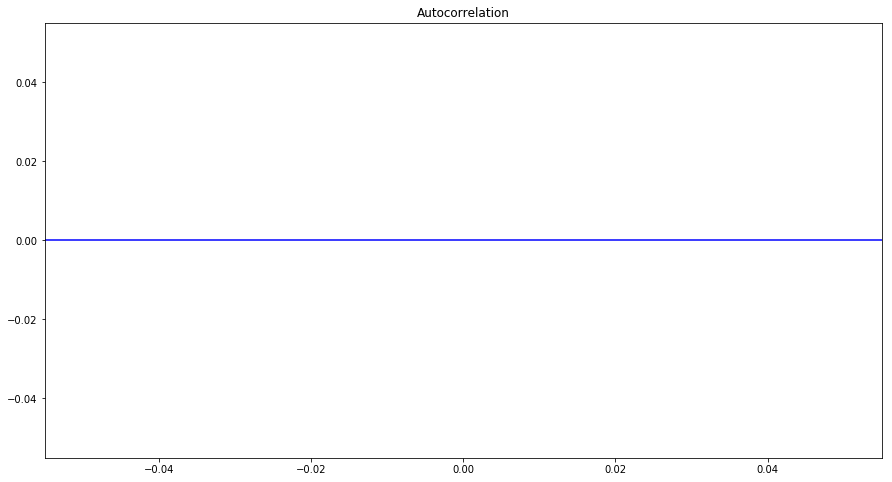

In [80]:
plot_acf(sd.resid)
plt.show()

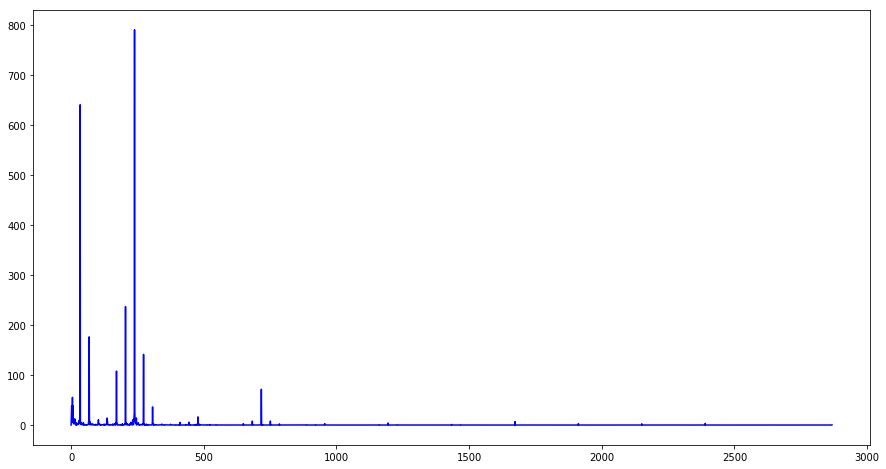

In [47]:
f, Pxx = signal.periodogram(m, scaling='spectrum')
plt.plot(Pxx)

In [10]:
tmp = Pxx.copy()
tmp.sort()
max_values = tmp[-2:]
max_freqs = [list(Pxx).index(v) for v in max_values]
print('Freq1: {:.0f} Freq2: {:.0f}'.format(1/max_freqs[1]*len(m), 1/max_freqs[0]*len(m)))

Freq1: 24 Freq2: 169


# Model fitting

In [27]:
def apply_differencing_filter(ts, lag):
    num_samples = len(ts)
    return ts[lag:num_samples] - ts[:num_samples-lag]
def apply_differencing_filters(ts, lags):
    for lag in lags:
        ts = apply_differencing_filter(ts, lag)
    return ts

[(1,), (24,), (168,), (1, 24), (1, 168), (24, 168), (1, 24, 168)]


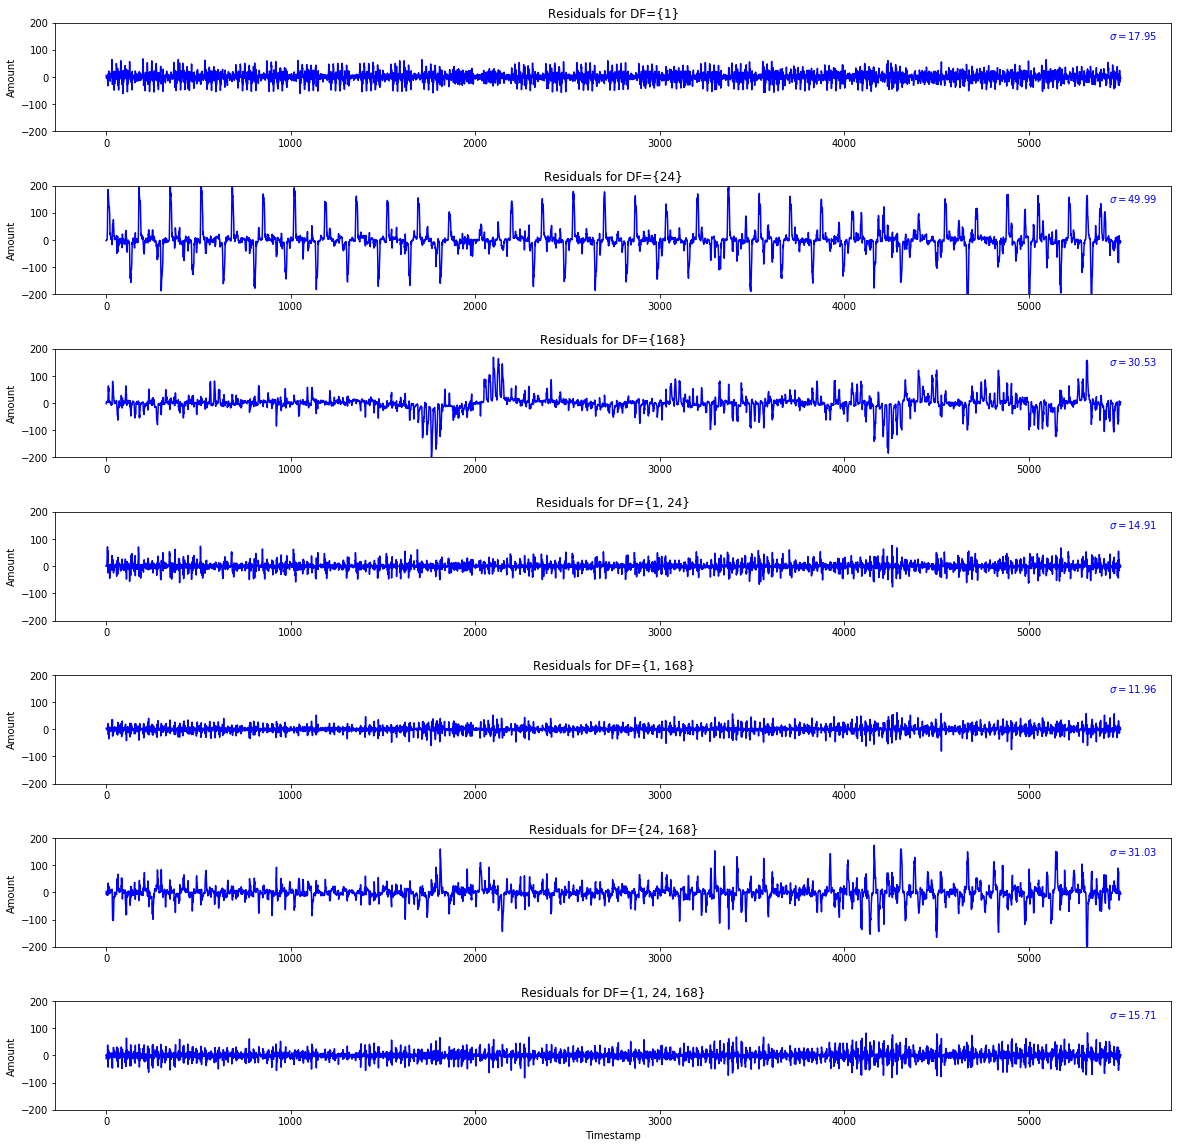

In [8]:
lags = [1, 24, 168]
combinations = []
for l in range(1,len(lags)+1):
    combinations.extend(list(itertools.combinations(lags, l)))
print(combinations)
m_diff = m
thres = 5500
fig, ax = plt.subplots(len(combinations), 1, figsize=(20,20))
plt.subplots_adjust(hspace = 0.5)
for i, lags in enumerate(combinations):
    
    m_diff = apply_differencing_filters(m, lags)[:thres]
    mean = np.mean(m_diff)
    std = np.std(m_diff)
    
    ax[i].text(5700, 130, r'$\sigma=${:.2f}'.format(std), ha='right', va='bottom', color='b')
    ax[i].plot(m_diff, c='b')
    ax[i].set_ylabel('Amount')
    ax[i].set_ylim([-200,200])
    if len(lags) == 1:
        ax[i].set_title('Residuals for DF={{{}}}'.format(str(lags)[1:-2]))
    else:
        ax[i].set_title('Residuals for DF={{{}}}'.format(str(lags)[1:-1]))
ax[-1].set_xlabel('Timestamp')
#plt.tight_layout()
#plt.savefig('data.png', dpi=300)
plt.show()

# Split data in train and test samples

In [29]:
ratio_test = 0.1
num_samples = len(m)
index_split = int(num_samples*(1-ratio_test))
train = m[:index_split]
test = m[index_split:]
print('We have {} samples for training and {} samples for testing.'.format(len(train), len(test)))

We have 5162 samples for training and 574 samples for testing.


### Assume differenced data is iid N(0, $\sigma^2$)

In [5]:
model = ARMA(m, order=(0, 1))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5736
Model:                     ARMA(0, 1)   Log Likelihood              -28085.454
Method:                       css-mle   S.D. of innovations             32.372
Date:                Tue, 09 Apr 2019   AIC                          56176.907
Time:                        21:50:30   BIC                          56196.871
Sample:                             0   HQIC                         56183.856
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        174.4303      0.800    217.977      0.000     172.862     175.999
ma.L1.y        0.8723      0.004    204.508      0.000       0.864       0.881
                                    Roots           

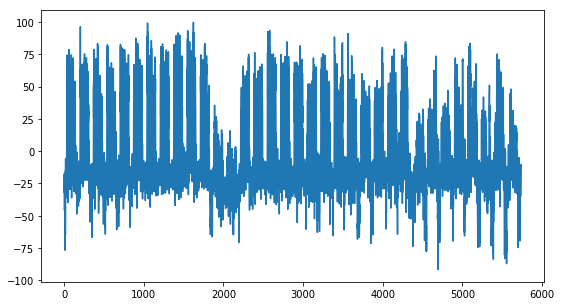

In [12]:
plt.plot(model_fit.resid)

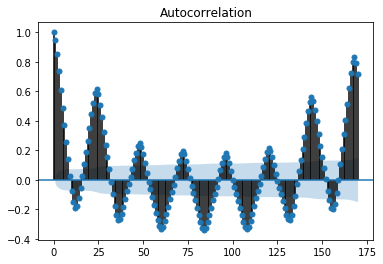

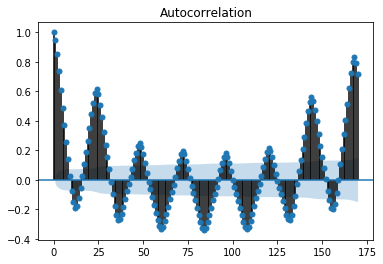

In [8]:
plot_acf(train, lags=170)

In [28]:
tmp = apply_differencing_filters(train, [1,24,168])

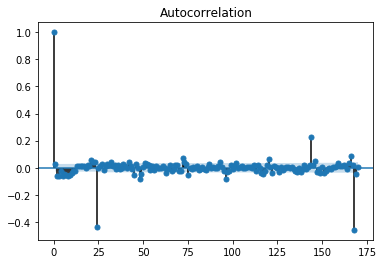

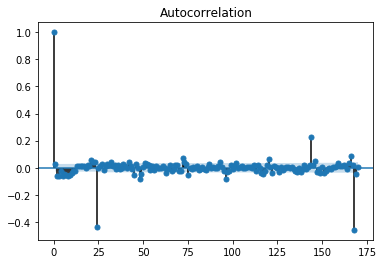

In [22]:
plot_acf(tmp, lags=170)

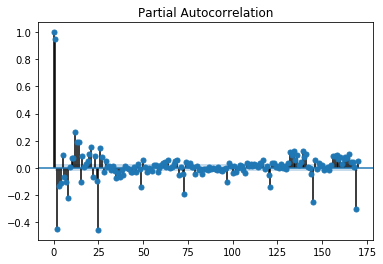

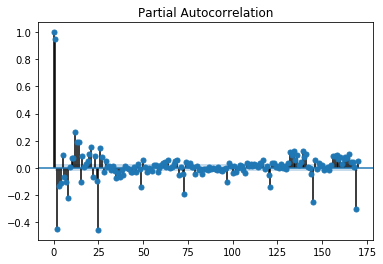

In [26]:
plot_pacf(train, lags=170)

# Grid Search for ARIMA model

In [7]:
model = auto_arima(train, max_p=10, max_q=10, trace=True, error_action='ignore',
                   suppress_warnings=True, stepwise=True)

Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=43530.241, BIC=43569.534, Fit time=3.288 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=44530.243, BIC=44543.341, Fit time=0.139 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=43580.740, BIC=43600.387, Fit time=0.282 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=43744.283, BIC=43763.929, Fit time=0.736 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=43562.061, BIC=43594.805, Fit time=1.543 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=43178.819, BIC=43224.661, Fit time=6.969 seconds
Fit ARIMA: order=(3, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=43492.093, BIC=43531.386, Fit time=2.220 seconds
Fit ARIMA: order=(3, 1, 3) seasonal_order=(0, 0, 0, 1); AIC=43125.705, BIC=43178.096, Fit time=9.629 seconds
Fit ARIMA: order=(4, 1, 4) seasonal_order=(0, 0, 0, 1); AIC=43005.075, BIC=43070.564, Fit time=9.405 seconds
Fit ARIMA: order=(3

In [39]:
def plot_prediction(model, test):

    fig, ax = plt.subplots(1, 1, figsize=(20,5))

    ax.scatter(np.arange(len(test)), test, marker='o', facecolors='None', edgecolors='b')
    ax.plot(test, color='b', linewidth=0.5, label='target')
    ax.plot(model.predict(len(test)), c='r', label='prediction')
    plt.legend()
    #plt.tight_layout()
    #plt.savefig('data.png', dpi=300)
    plt.show()

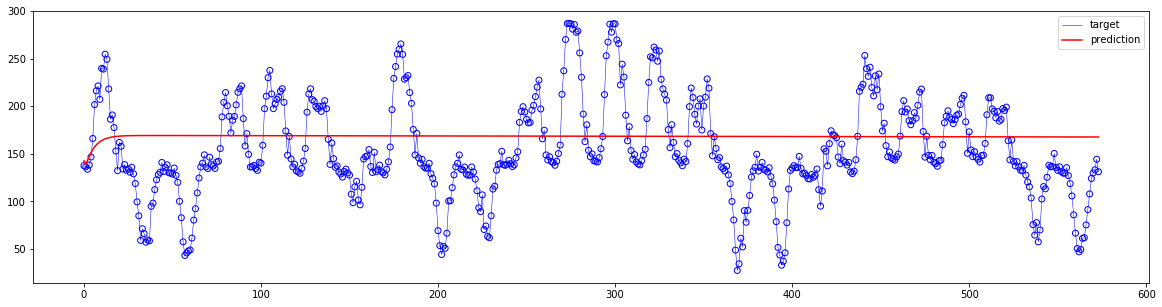

In [40]:
plot_prediction(model, test)

In [21]:
model_2 = auto_arima(train, seasonal=True, m=24, trace=True, error_action='ignore',
                   suppress_warnings=True, stepwise=True)

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 1, 1, 24); AIC=39033.458, BIC=39085.813, Fit time=120.106 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 24); AIC=54631.409, BIC=54644.498, Fit time=0.707 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 24); AIC=41811.639, BIC=41837.816, Fit time=21.964 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 24); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 1, 1, 24); AIC=39218.608, BIC=39264.419, Fit time=82.179 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 1, 1, 24); AIC=38927.760, BIC=38986.660, Fit time=259.295 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 1, 0, 24); AIC=40381.749, BIC=40434.105, Fit time=149.443 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 1, 2, 24); AIC=38886.052, BIC=38951.496, Fit time=344.997 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(2, 1, 2, 24); AIC=38979.984, BIC=39038.884, Fit time=274.488 seconds
Fit ARIMA: o

In [24]:
adf_test = ADFTest(alpha=0.05)
adf_test.is_stationary(m)

(0.01, False)

In [31]:
model_3 = auto_arima(train, max_p=10, max_q=10, stationary=True, trace=True, error_action='ignore',
                   suppress_warnings=True, stepwise=True)

Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=43120.012, BIC=43159.307, Fit time=5.645 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=56297.472, BIC=56310.570, Fit time=0.086 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=44408.676, BIC=44428.323, Fit time=0.208 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=50592.374, BIC=50612.021, Fit time=1.224 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=43428.661, BIC=43461.407, Fit time=2.228 seconds
Fit ARIMA: order=(3, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=43132.616, BIC=43165.361, Fit time=2.187 seconds
Fit ARIMA: order=(2, 0, 3) seasonal_order=(0, 0, 0, 1); AIC=43000.587, BIC=43046.430, Fit time=4.969 seconds
Fit ARIMA: order=(3, 0, 4) seasonal_order=(0, 0, 0, 1); AIC=42973.804, BIC=43032.746, Fit time=9.609 seconds
Fit ARIMA: order=(2, 0, 4) season

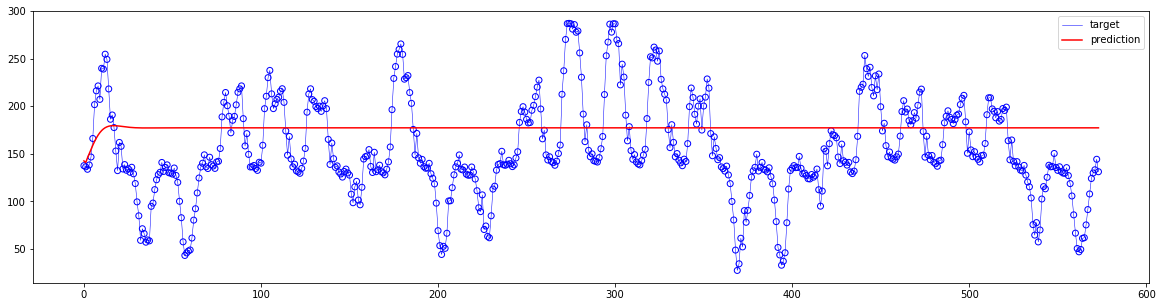

In [41]:
plot_prediction(model_3, test)

In [49]:
model_4 = auto_arima(train, start_p=10, start_q=10, max_p=10, max_q=10, max_order=30, stationary=True, trace=True, error_action='ignore',
                   suppress_warnings=True)

Fit ARIMA: order=(10, 0, 10) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=56297.472, BIC=56310.570, Fit time=0.094 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=44408.676, BIC=44428.323, Fit time=0.201 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=50592.374, BIC=50612.021, Fit time=1.217 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=43257.920, BIC=43284.117, Fit time=0.669 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=43132.616, BIC=43165.361, Fit time=2.156 seconds
Fit ARIMA: order=(3, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=43544.017, BIC=43570.214, Fit time=1.768 seconds
Fit ARIMA: order=(3, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=43120.399, BIC=43159.693, Fit time=4.978 seconds
Fit ARIMA: order=(3, 0, 0) seasonal_order=(0,

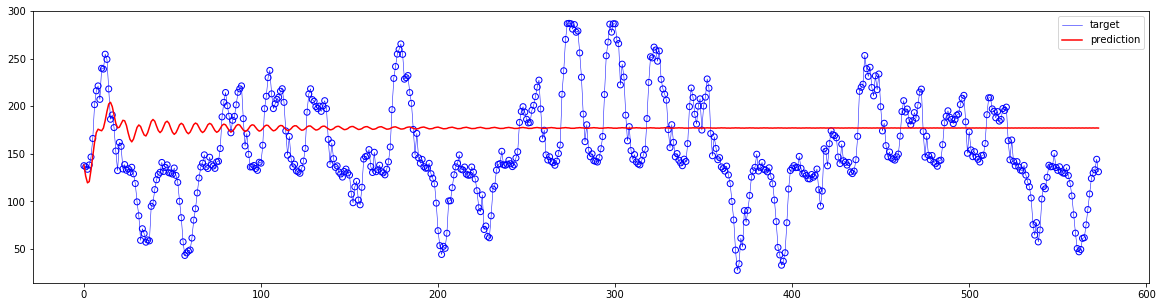

In [51]:
plot_prediction(model_4, test)

In [50]:
model_5 = auto_arima(train, start_p=2, start_q=10, max_p=10, max_q=10, max_order=30, stationary=True, trace=True, error_action='ignore',
                   suppress_warnings=True, stepwise=True)

Fit ARIMA: order=(2, 0, 10) seasonal_order=(0, 0, 0, 1); AIC=42503.501, BIC=42595.188, Fit time=15.960 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=56297.472, BIC=56310.570, Fit time=0.084 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=44408.676, BIC=44428.323, Fit time=0.202 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=50592.374, BIC=50612.021, Fit time=1.230 seconds
Fit ARIMA: order=(1, 0, 10) seasonal_order=(0, 0, 0, 1); AIC=42940.072, BIC=43025.210, Fit time=6.395 seconds
Fit ARIMA: order=(3, 0, 10) seasonal_order=(0, 0, 0, 1); AIC=42430.895, BIC=42529.131, Fit time=17.044 seconds
Fit ARIMA: order=(3, 0, 9) seasonal_order=(0, 0, 0, 1); AIC=42523.916, BIC=42615.603, Fit time=13.683 seconds
Fit ARIMA: order=(2, 0, 9) seasonal_order=(0, 0, 0, 1); AIC=42522.217, BIC=42607.355, Fit time=13.645 seconds
Fit ARIMA: order=(4, 0, 10) seasonal_order=(0, 0, 0, 1); AIC=42449.196, BIC=42553.981, Fit time=18.525 seconds
Total fit 

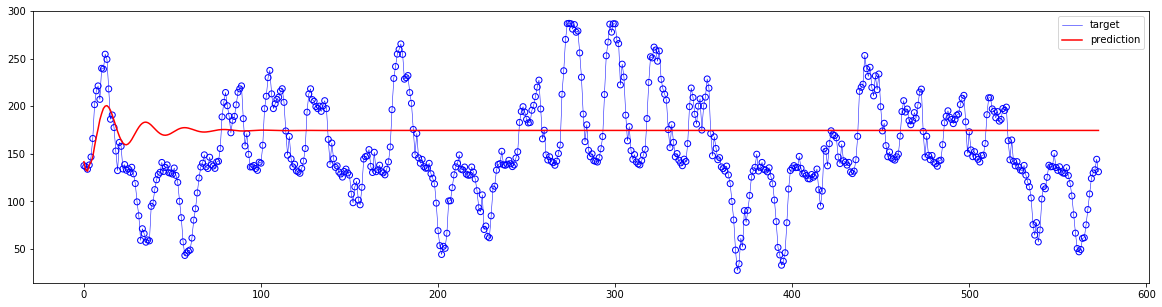

In [52]:
plot_prediction(model_5, test)

In [30]:
model_6 = auto_arima(train, start_p=169, start_q=0, max_p=180, max_q=10, max_order=200, stationary=True, trace=True, error_action='ignore',
                   suppress_warnings=True, stepwise=True)

KeyboardInterrupt: 

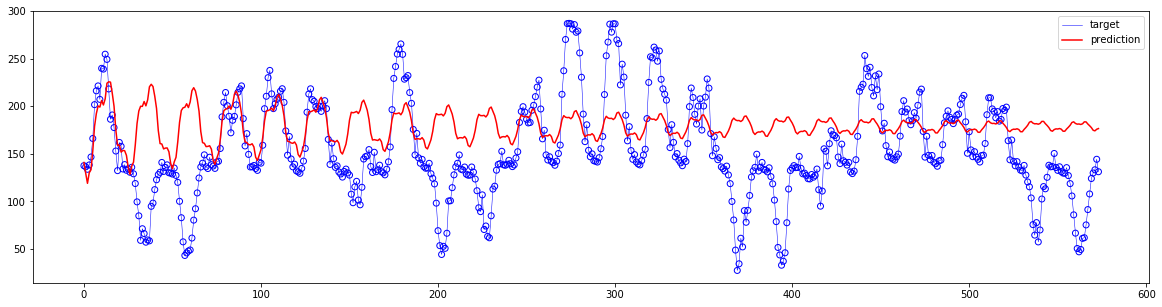

In [54]:
plot_prediction(model_6, test)